# <center> Heat Budget <center> 

In [1]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'Tav.nc'

In [2]:
# Load in Modules
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
#import glob
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
import SG as SG
from HB_Plot import nf, fmt
%matplotlib inline

if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ']

# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'


# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/'+Year
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)
# Set Parameters
alpha = 2.000000E-04
g = -9.81
rho_0 = 1000
C_p = 3985
gridfilepath = x+'/3daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc', 'r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
Zmatrix = np.zeros((len(Z), len(Yc)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
dzc = Z[0:len(Z)-1]-Z[1:len(Z)]
ny = len(Y)
nz = len(Z)
Zmatrix[:,:] = np.apply_along_axis(np.multiply, 0, Zmatrix, dz)

In [3]:
# Surface Heat Fluxes
Ly = 2000e3
Lx = 1000e3
nx = np.round(Lx/dx)
ny = np.round(Ly/dx)
Q_0 = 10
Q = np.zeros_like(Yc)
pi = math.pi
Q=np.zeros(np.shape(Q))
Q[0:int(5*ny/36)] = Q_0*(np.cos(Yc[0:int(5*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((Yc[int(5*ny/36):int(20*ny/36)]-Yc[int(5*ny/36)])*(pi/(Yc[int(15*ny/36)]))))
Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(Yc[0:int(10*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Psipred = -(Q)/(rho_0*C_p)

\begin{equation}
\overline{v}\frac{\partial \overline{T}}{\partial y} + \overline{w}\frac{\partial \overline{T}}{\partial z} + \frac{\partial \overline{v'T'}}{\partial y} + \frac{\partial \overline{w'T'}}{\partial z}  = Q + Diff
\end{equation}

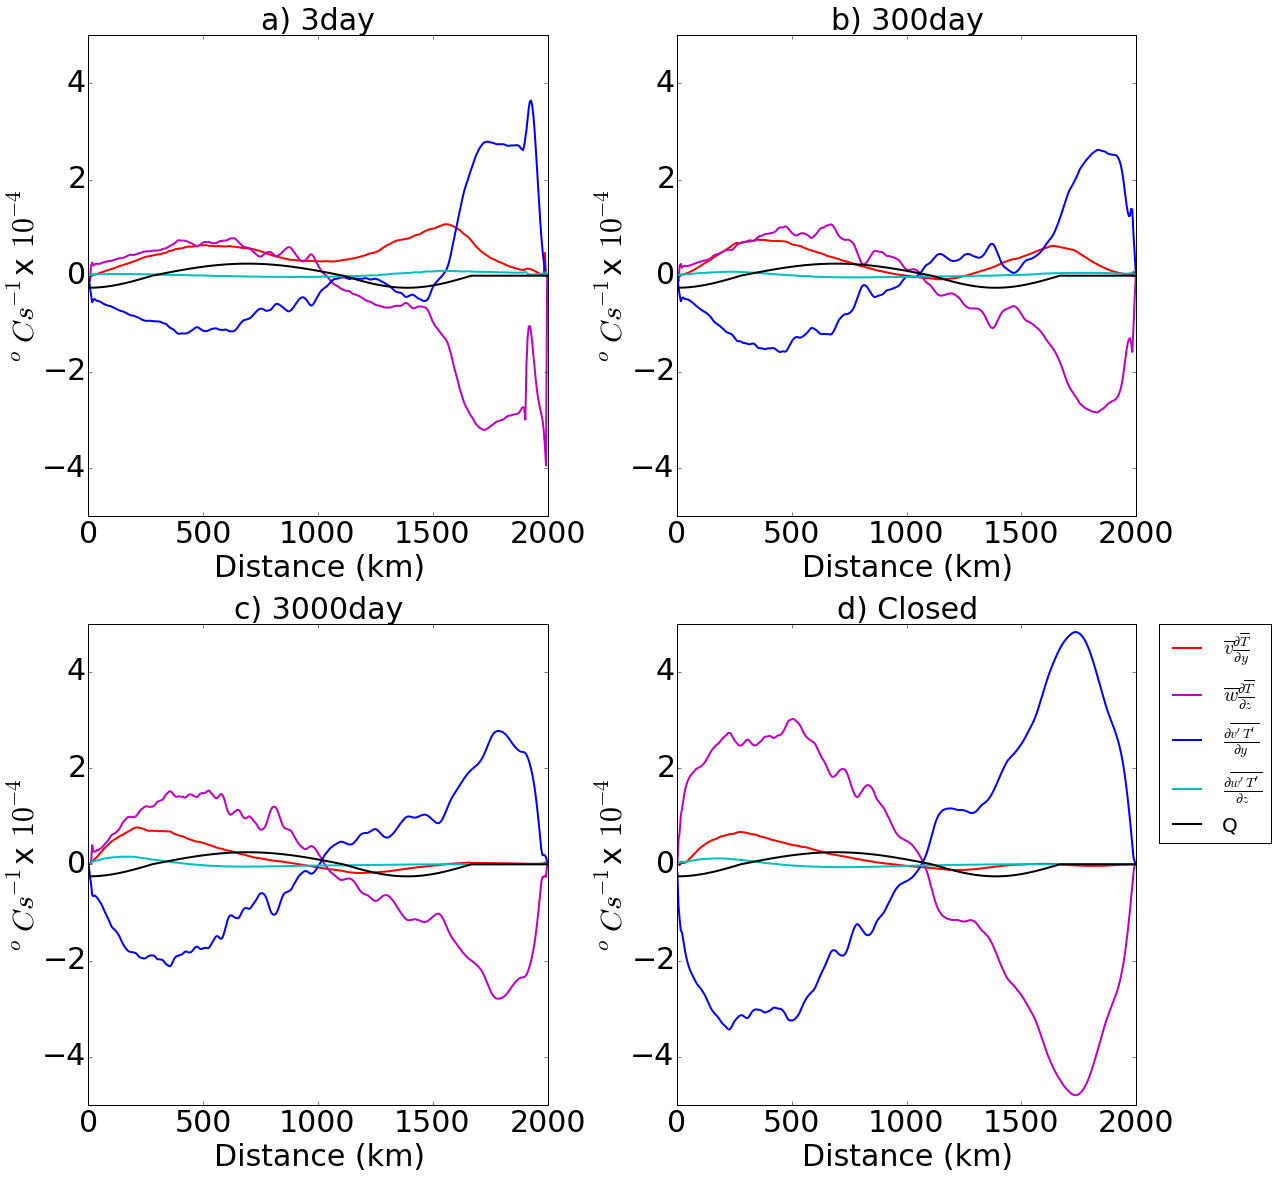

In [4]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = numba_regridy(VTTav) - numba_regridy(VTav)*TTav
    WpTp = numba_regridz(WTTav) - numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav,Yc)
    Tz = ddz_cgrid_centered(TTav, Z)
    VTy = nansum(numba_regridy(VTav)*Ty*Zmatrix,axis=0)
    WTz = nansum(numba_regridz(WTav)*Tz*Zmatrix,axis=0)
    WpTpz = nansum(ddz_cgrid_centered(WpTp, Z)*Zmatrix,axis = 0)
    VpTpy = nansum(ddy_cgrid_centered(VpTp, Yc)*Zmatrix,axis = 0)
    p = plt.plot(Yc/1000,VTy*10**5,'r',linewidth=2)
    p = plt.plot(Yc/1000,WTz*10**5,'m',linewidth=2)
    p = plt.plot(Yc/1000,VpTpy*10**5,'b',linewidth=2)
    p = plt.plot(Yc/1000,WpTpz*10**5,'c',linewidth=2)
    p = plt.plot(Yc/1000,Psipred*10**5,'k',linewidth=2)
    plt.ylim(-5,5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-4}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\overline{v}\frac{\partial \overline{T}}{\partial y}$',r'$\overline{w}\frac{\partial \overline{T}}{\partial z}$',r'$\frac{\partial \overline{v^\prime T^\prime}}{\partial y}$',r'$\frac{\partial \overline{w^\prime T^\prime}}{\partial z}$','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

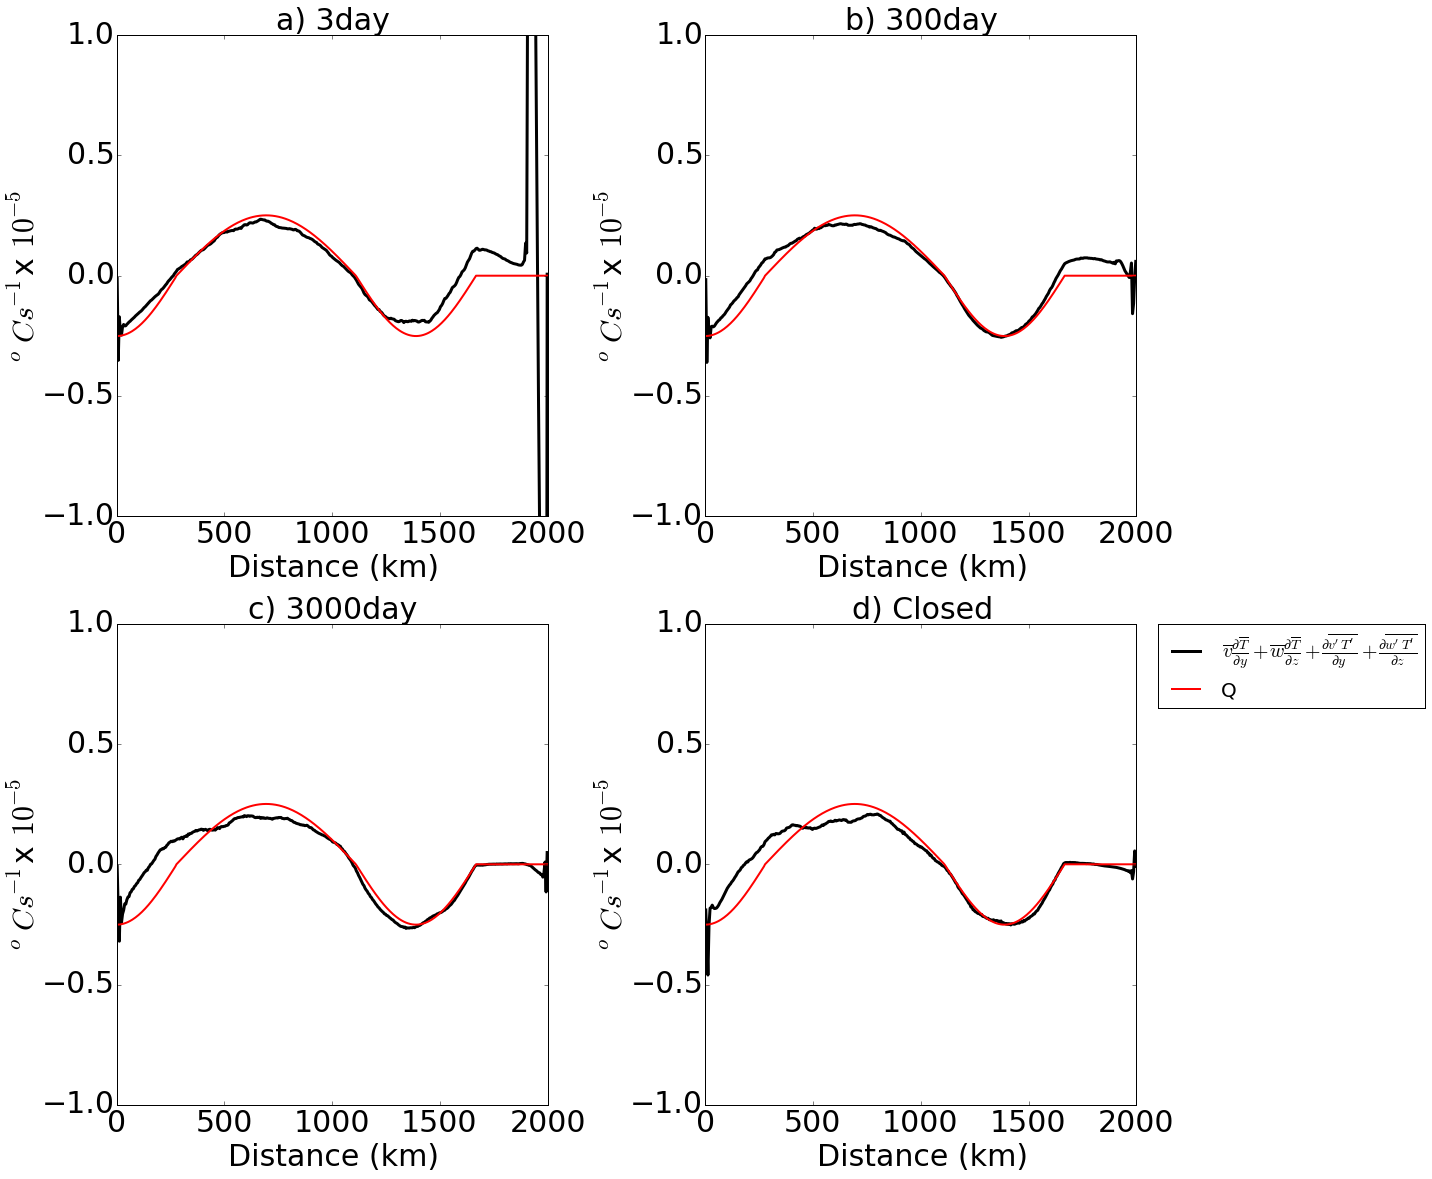

In [6]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = numba_regridy(VTTav) - numba_regridy(VTav)*TTav
    WpTp = numba_regridz(WTTav) - numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav,Yc)
    Tz = ddz_cgrid_centered(TTav, Z)
    VTy = numba_regridy(VTav)*Ty
    WTz = numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp,Z)
    VpTpy = ddy_cgrid_centered(VpTp, Yc)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)
    p = plt.plot(Yc/1000,np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)*10**5,'k',linewidth=3)
    p = plt.plot(Yc/1000,Psipred*10**5,'r',linewidth=2)
    plt.ylim(-1,1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-5}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\overline{v}\frac{\partial \overline{T}}{\partial y} + \overline{w}\frac{\partial \overline{T}}{\partial z} + \frac{\partial \overline{v^\prime T^\prime}}{\partial y} + \frac{\partial \overline{w^\prime T^\prime}}{\partial z}$','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

# Alternatively... #

The v'T' and w'T' terms can be decomposed into an along-isopycnal term and a horizontal component:

\begin{equation}
\left(\overline{v'T'},\overline{w'T'}\right) =  \underbrace{\left(v'T', S_p . v'T' \right)}_\text{along $\overline{T}$}  + \underbrace{\left(0, w'T'- S_p.v'T'\right)}_\text{remaining vertical}, 
\end{equation}

which can be substituted back in to the buoyancy budget:

\begin{equation}
\overline{v}\frac{\partial \overline{T}}{\partial y } + \overline{w}\frac{\partial \overline{T}}{\partial z } + \frac{\partial \left( \overline{v'T'}\right)}{\partial y }+ \frac{\partial \overline{v'T'}.S_p}{\partial z } + \frac{\partial \overline{w'T'}-S_p.\overline{v'T'}}{\partial z } = \frac{\partial B}{\partial z}.
\end{equation}

The along isopycnal eddy fluxes can be written as:

\begin{equation}
\textbf{v}^* . \nabla \overline{T}
\end{equation}

and 

\begin{equation}
v^* = \frac{\partial \psi ^*}{\partial z}, \quad w^* = \frac{\partial \psi ^*}{\partial y} \\ \, \text{ and } \, \\
\overline{v} = \frac{\partial \overline{\psi } }{\partial z}, \quad \overline {w} = \frac{\partial \overline{\psi} }{\partial y}.
\end{equation}
Substituting these in gives:

\begin{equation}
v^* \frac{\partial \overline{T}}{\partial y }= \frac{\partial \overline{v'T'}}{\partial y}, \quad w^* \frac{\partial \overline{T}}{\partial z } = \frac{\partial S_p.\overline{v'T'}}{\partial z}. 
\end{equation}

So becomes:

\begin{equation}
\textbf{$v_{res}$}. \nabla \overline{T} = \frac{\partial B}{\partial z}- \frac{\partial \left(\overline{w'T'}-S_p.\overline{v'T'}\right)}{\partial y }.
\end{equation}

Residual mean theory as used in Marshall2003 allows for further simplifications such as neglecting the diabatic term. When studying the effect of a changing stratification north of the ACC, such neglect leads to serious errors in the calculation. 
In terms of the ROC we must write:

\begin{equation}
J(\psi_{res},\overline{T})=\frac{\partial B}{\partial z}- \frac{\partial \left(\overline{w'T'}-S_p.\overline{v'T'}\right)}{\partial z },
\end{equation} 

which can be alternatively written as

\begin{equation}
J(\Psi_{res},\overline{T}) = \underbrace{\frac{\partial B}{\partial z}}_\text{Air-sea fluxes} - \underbrace{\frac{\partial \overline{w'T' - \Psi ^*. T_z.S_p  }}{\partial z }}_\text{Diabatic eddies} 
\end{equation} 

## LETS TRY THAT THEN

\begin{equation}
   \Psi_{res}  |_{hml}   =  \left( Q + \int_{-hml}^{0}\frac{\partial \left(w'T' - \overline{v'T'}.Sp  \right)}{\partial z} \mathrm{d}z \right) \left(  \frac{\partial \overline{b} }{\partial y }  \right)^{-1} 
\end{equation}

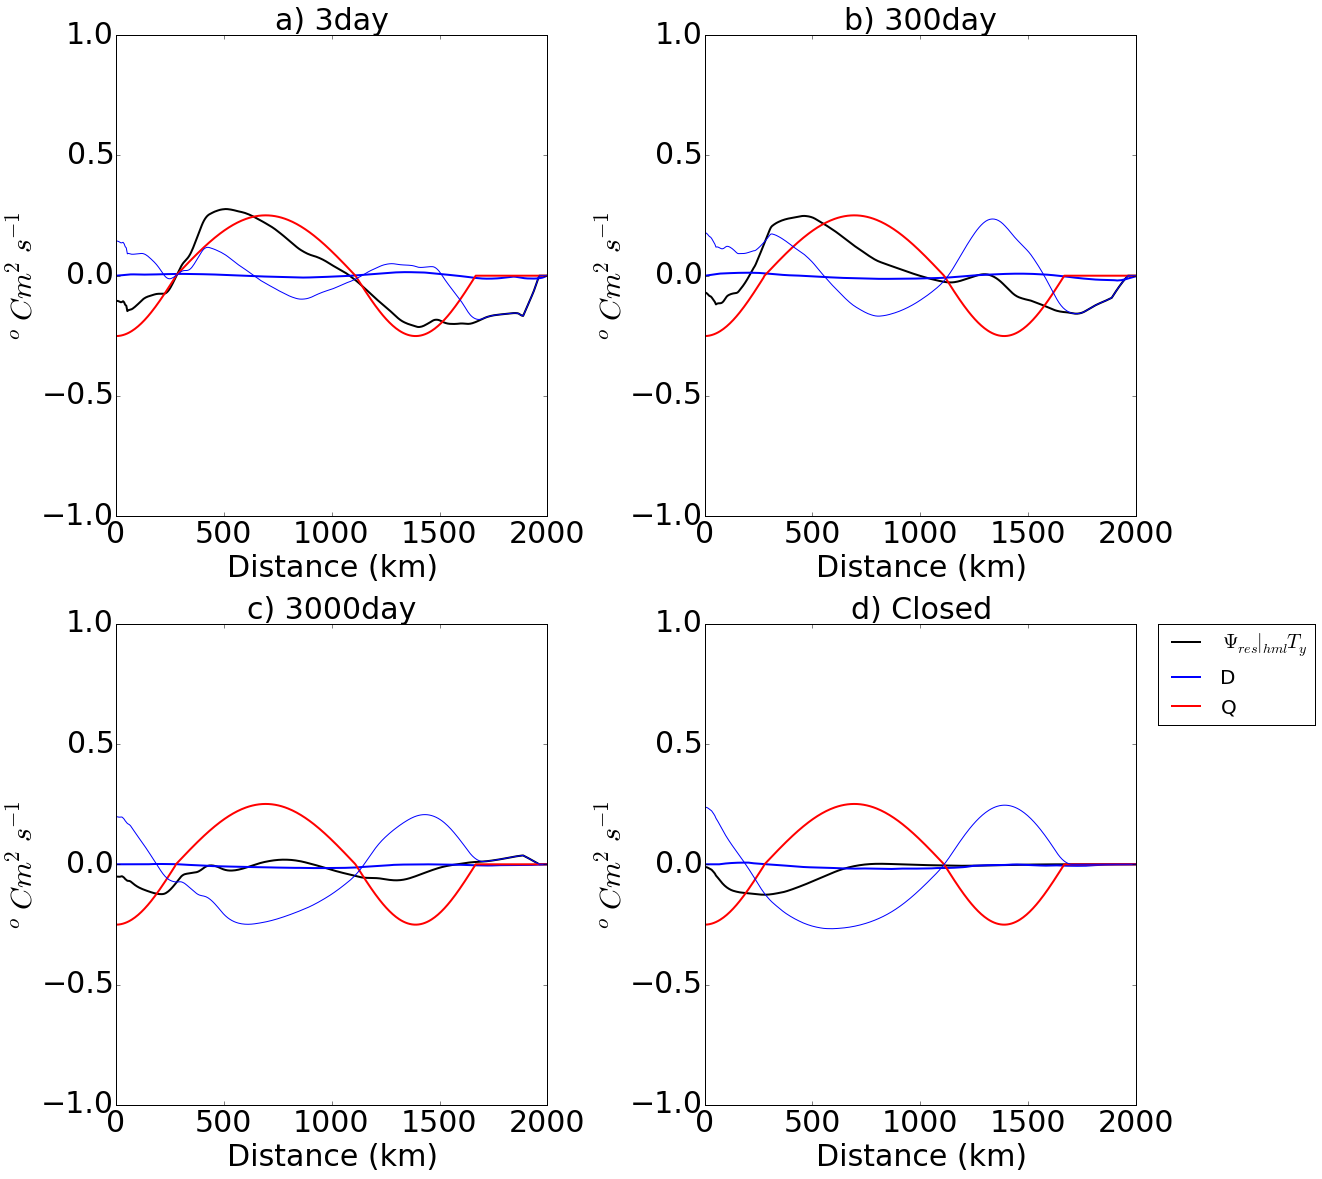

In [11]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Psi_res(y,z)
    
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/PSI.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.mean(lvrho, axis=3)  # Zonal average
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)
       
    # Temp field
    
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    T = numba_regridz(numba_regridy(get_psi_iso_z(Rho_matrix, th,Z)))
    
    for kk in range(len(psi[:,1])):
        if np.mean(psi[kk,10:-50])>0:
            if psi[kk,320]<0.9*np.max(psi[kk,10:-50]):
                continue
            psi[kk,:]=np.max(psi[kk,10:-50])
        else:
            if psi[kk,300]>0.5*np.min(psi[kk,10:-50]):
                continue
            psi[kk,:]=np.min(psi[kk,10:-50])
    
    psi[psi>1.5] = 1.5

    
    psiz = numba_regridz(numba_regridy(get_psi_iso_z(psi, th,Z)))

    
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = numba_regridy(VTTav) - numba_regridy(VTav)*TTav
    WpTp = numba_regridz(WTTav) - numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav,Yc)
    Tz = ddz_cgrid_centered(TTav,Z)
    VTy = numba_regridy(VTav)*Ty
    WTz = numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp,Z)
    VpTpy = ddy_cgrid_centered(VpTp,Yc)
    Ty = ddy_cgrid_centered(TTav,Yc)
    Tz = ddz_cgrid_centered(TTav,Z)
    VTy = numba_regridy(VTav)*Ty
    WTz = numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp,Z)
    VpTpy = ddy_cgrid_centered(VpTp,Yc)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)-Psipred
    np.apply_along_axis(np.multiply, 1, ones_like(Ty), Ty[0,:])
    Sp_est = - (np.apply_along_axis(np.multiply, 0, ones_like(Ty),Tz[:,-2])/
                (np.apply_along_axis(np.multiply, 1, ones_like(Ty), Ty[0,:])))
        
    Tavlat = TTav
    V = file2.variables["VVEL"][:]
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.mean(Vtave, axis=2)
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    psiz = np.pad(psiz, pad_width=npad, mode='constant',
                 constant_values=0)
    Psied = psiz - numba_regridz(numba_regridy(psi))
  
    # Slope from layers
    #SP = ddy_cgrid_centered(depths,Yc)
    #SPZ = get_psi_iso_z(SP,th,Z)
    D = (ddy_cgrid_centered(VpTp,Yc))[0::,:]
    for jj in range(len(Yc)):
        if np.where(Tz[2:,jj]==np.max(Tz[2:,jj]))[0][0]==0 and i<2:
            D[2::,jj] = 0
        else:
            D[np.where(Tz[2:,jj]==np.max(Tz[2:,jj]))[0][0]::,jj] = 0
    Diff[-25::]=0
    D = -np.sum(D,axis=0)
    #D = -np.sum((ddz_cgrid_centered(WpTp+Psied*Ty,Z)*Zmatrix)[0::,:],axis=0)
    Q = Psipred
    ROC = psiz[0,:]*Ty[0,:]
    ROC[-15::] = 0
    ROC[0] = 0

    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC*10**5,15,1),'k',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(D*10**5,27,1),'b',linewidth=2)
    p = plt.plot(Yc/1000,Q*10**5,'r',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay((ROC-Q)*10**5,15,1),'b',linewidth=1)
    plt.ylim(-1,1)

    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oC m^2 s^{-1} $', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=plt.legend([r'$\Psi_{res}|_{hml}T_y$','D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

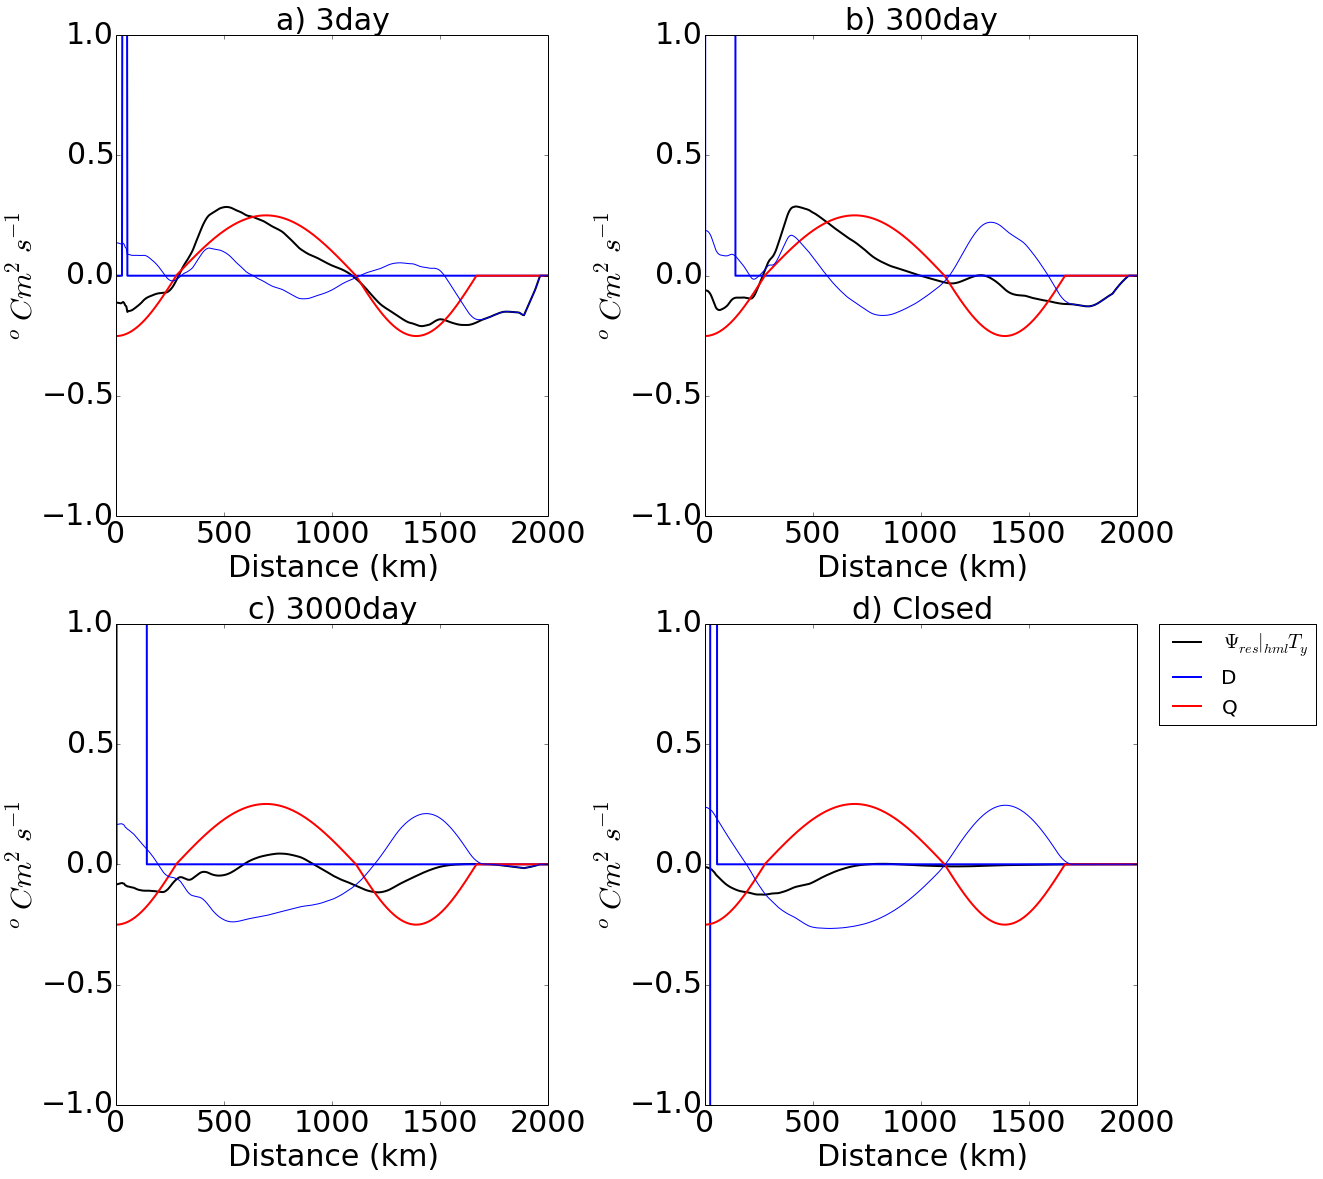

In [315]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Psi_res(y,z)
    
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/PSI.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.mean(lvrho, axis=3)  # Zonal average
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)
    Va = file2read.variables["LaVa1TH"][:].mean(axis=3).mean(axis=0)
    P = file2read.variables["LaPs1TH"][:].mean(axis=3).mean(axis=0)
    # Temp field
    Paz =  get_psi_iso_z(P, th[:,:],Z)
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    Tlayers = Rho[1:-1]
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(Va),Tlayers)
    depths =np.cumsum(th,axis=0)-2985
    SP = ddy_cgrid_centered(depths,Yc)
    Va[P>0.98]=0
    Vaz =  get_psi_iso_z(Va*Rho_matrix, th[:,:],Z)
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    T = numba_regridz(numba_regridy(get_psi_iso_z(Rho_matrix, th,Z)))
    
    for kk in range(len(psi[:,1])):
        if np.mean(psi[kk,10:-50])>0:
            if psi[kk,320]<0.9*np.max(psi[kk,10:-50]):
                continue
            psi[kk,:]=np.max(psi[kk,10:-50])
        else:
            if psi[kk,300]>0.5*np.min(psi[kk,10:-50]):
                continue
            psi[kk,:]=np.min(psi[kk,10:-50])
    
    psi[psi>1.5] = 1.5

    
    psiz = numba_regridz(numba_regridy(get_psi_iso_z(psi, th,Z)))

    
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = numba_regridy(VTTav) - numba_regridy(VTav)*TTav
    WpTp = numba_regridz(WTTav) - numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav,Yc)
    Tz = ddz_cgrid_centered(TTav,Z)
    VTy = numba_regridy(VTav)*Ty
    WTz = numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp,Z)
    VpTpy = ddy_cgrid_centered(VpTp,Yc)
    Ty = ddy_cgrid_centered(TTav,Yc)
    Tz = ddz_cgrid_centered(TTav,Z)
    VTy = numba_regridy(VTav)*Ty
    WTz = numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp,Z)
    VpTpy = ddy_cgrid_centered(VpTp,Yc)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)-Psipred
    np.apply_along_axis(np.multiply, 1, ones_like(Ty), Ty[0,:])
    Sp_est = - (np.apply_along_axis(np.multiply, 0, ones_like(Ty),Tz[:,-2])/
                (np.apply_along_axis(np.multiply, 1, ones_like(Ty), Ty[0,:])))
        
    Tavlat = TTav
    V = file2.variables["VVEL"][:]
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.mean(Vtave, axis=2)
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    psiz = np.pad(psiz, pad_width=npad, mode='constant',
                 constant_values=0)
    Psied = psiz - numba_regridz(numba_regridy(psi))
  
    # Slo depths =np.cumsum(th[::-1,:],axis=0)pe from layers
 
    SPZ = get_psi_iso_z(SP,th,Z)
    D = (ddy_cgrid_centered(VpTp-WpTp/numba_regridy(-SPZ),Y)*Zmatrix)[0::,:]
    # D = (ddz_cgrid_centered(WpTp-VpTp*numba_regridy(-SPZ),Z)*Zmatrix)[0::,:]
    for jj in range(len(Yc)):
        if np.where(Tz[2:,jj]==np.max(Tz[2:,jj]))[0][0]==0 and i<2:
            D[2::,jj] = 0
        else:
            D[np.where(Tz[2:,jj]==np.max(Tz[2:,jj]))[0][0]::,jj] = 0
    Diff[-25::]=0
    D = -np.sum(D,axis=0)
    #D = -np.sum((ddz_cgrid_centered(WpTp+Psied*Ty,Z)*Zmatrix)[0::,:],axis=0)
    Q = Psipred
    ROC = psiz[0,:]*Ty[0,:]
    ROC[-15::] = 0
    ROC[0] = 0

     
    D = -np.sum(numba_regridy(Vaz),axis=0)
    
    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC*10**5,15,1),'k',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(D*10**5,15,1),'b',linewidth=2)
    p = plt.plot(Yc/1000,Q*10**5,'r',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay((ROC-Q)*10**5,15,1),'b',linewidth=1)
    plt.ylim(-1,1)

    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oC m^2 s^{-1} $', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=plt.legend([r'$\Psi_{res}|_{hml}T_y$','D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

In [14]:
def z_to_T(PSISO, Z, Th):
    """Z to T"""

    psi_iso = PSISO
    # figure out the depth of each layer
    h = Th
    # psi_iso is defined at the *bottom* of each layer,
    # therefore we want the depth at the bottom of the layer
    z = cumsum(h, axis=0) - (sum(th,axis=0))
    # interpolate to center z points
    psi_iso_z = zeros((len(h[:,1]),ny))
    for j in arange(ny-1):
        psi_iso_z[:,j] = interp(z[:,j],Z[::-1], psi_iso[::-1,j])
    return psi_iso_z

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:131: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:131: RuntimeWarning: invalid value encountered in divide


ValueError: operands could not be broadcast together with shapes (400,) (401,) 

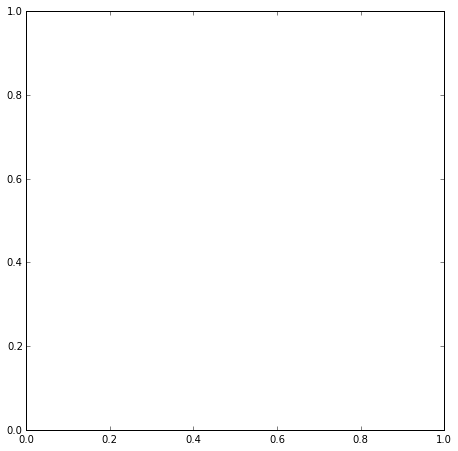

In [19]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Psi_res(y,z)
    
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/PSI.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.mean(lvrho, axis=3)  # Zonal average
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)
    psi2 = psi
    psiz2 = numba_regridz(numba_regridy(get_psi_iso_z(psi, th,Z)))
    depths =np.cumsum(th[::-1,:],axis=0)
    mld = np.zeros_like(Y)
    for kk in range(len(psi[:,1])):
        if np.mean(psi[kk,10:-50])>0:
           
            if psi[kk,310]<0.8*np.max(psi[kk,10:-50]):
                continue
            psi[kk,:]=np.max(psi[kk,10:-50])
            
        else:
           
            if abs(psi[kk,300])>0.8*abs(np.min(psi[kk,10:-50])):
                continue
            psi[kk,:]=np.min(psi[kk,10:-50])
            
    psiz = numba_regridz(numba_regridy(get_psi_iso_z(psi, th,Z)))
   
    #for jj in range(len(Y))
    # Temp field
    
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    T = numba_regridz(numba_regridy(get_psi_iso_z(Rho_matrix, th,Z)))
    
    
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = numba_regridy(VTTav) - numba_regridy(VTav)*TTav
    WpTp = numba_regridz(WTTav) - numba_regridz(WTav)*TTav
    VTTav = numba_regridy(VTTav)
    WTTav = numba_regridy(WTTav)
    Ty = ddy_cgrid_centered(TTav,Yc)
    Tz = ddz_cgrid_centered(TTav,Z)
    VTy = numba_regridy(VTav)*Ty
    WTz = numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp,Z)
    VpTpy = ddy_cgrid_centered(VpTp,Yc)
    Ty = ddy_cgrid_centered(TTav,Yc)
    Tz = ddz_cgrid_centered(TTav,Z)
    VTy = numba_regridy(VTav)*Ty
    WTz = numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp,Z)
    VpTpy = ddy_cgrid_centered(VpTp,Yc)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)-Psipred
    
  
    Tavlat = TTav
    V = file2.variables["VVEL"][:]
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.mean(Vtave, axis=2)
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    psiz = np.pad(psiz, pad_width=npad, mode='constant',
                 constant_values=0)
    Psied = psiz - numba_regridz(numba_regridy(psi))
    Psied = np.pad(Psied, pad_width=npad, mode='constant',
                 constant_values=0)


    # Use layers field
    Ty_l = ddy_cgrid_centered(T,Yc)
    Tz_l = ddz_cgrid_centered(T,Z)
    Ty_l[isnan(Ty_l)] = 0
    Tz_l[isnan(Tz_l)] = 0
    ROC = psiz[0,:]*Ty[0,:]
    ROC[-15::] = 0
    ROC[0] = 0
    #ROC = ROCmixed*Ty[0,:]
    # int dB/dZ dz = Q
    Tz_l = np.pad(Tz_l, pad_width=npad, mode='constant',
                 constant_values=0)
    Ty_l = np.pad(Ty_l, pad_width=npad, mode='constant',
                 constant_values=0)
    # Diabatic Eddy Flux
    # int dVT/dy - d(WT/Sp)/dy dz
    # Careful there are some crazy numbers appearing 
    # REMOVE NANS AND INFS
    
   
    Ty[Ty<2*10**-6] = 2*10**-6
    Tz[Tz<10**-6] = 10**-6
    Sp = -Ty/Tz
    Sp[isinf(Sp)]=0
    Sp[isnan(Sp)]=0
    
    # Slope from layers
    SP = -ddy_cgrid_centered(depths,Yc)
    
    # Psied * Ty_l = W'T'
    Ty = abs(Ty)
    WT = -numba_regridz(Psied) * Ty
    VT = numba_regridz(Psied) 
    Sp_l = -Ty_l/Tz_l
    lvl = np.arange(-0.3,0.3,0.03)/50
    AD = WT/Sp
    AD[isnan(AD)]=0
    AD[isinf(AD)]=0
    Sp = -abs(Sp)
    WTiso = z_to_T(WpTp,Z,th)
    VTiso = z_to_T(VpTp,Z,th)
    DE = WTiso- numba_regridy(SP)*VTiso
    D = ddz_cgrid_centered(DE,depths)
    D = get_psi_iso_z(D,th,Z)
    
    #D[10::] = 0
    #D = ddy_cgrid_centered(D,Y)
    
    for jj in range(len(Yc)):
        if np.where(Tz[2:,jj]==np.max(Tz[2:,jj]))[0][0]==0 and i<2:
            D[2::,jj] = 0
        else:
            D[np.where(Tz[2:,jj]==np.max(Tz[2:,jj]))[0][0]::,jj] = 0
    Diff[-25::]=0
    Q = Psipred
    #D[:,-5::]=0
    D = -np.nansum((numba_regridy(D)*Zmatrix)[0::,0:400],axis =0)

    p = plt.plot(Yc/1000,(ROC*10**5),'k',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay((D)*10**5,19,1),'b',linewidth=2)
    p = plt.plot(Yc/1000,Q*10**5,'r',linewidth=2)
    # p = plt.plot(Yc/1000,SG.savitzky_golay(D*10**5,15,1)+Diff*10**5,'--b',linewidth=1)
    p = plt.plot(Yc/1000,((ROC-Diff-Q)*10**5),'b',linewidth=1)
    plt.ylim(-1,1)

    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oC m^2 s^{-1} $', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    
plt.tight_layout()
lgd=plt.legend([r'$\Psi_{res}|_{hml}T_oy$','D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)